In [14]:
import numpy as np
from matplotlib import pyplot as plt
import lineax as lx
from jax import vmap, numpy as jnp, jit
from functools import partial
from tqdm import tqdm
import diffrax
import equinox as eqx
from time import time

# We'll need this dummy stepper
class Stepper(diffrax.Euler):
    def step(self, terms, t0, t1, y0, args, solver_state, made_jump):
        del solver_state, made_jump
        y1 = terms.vf(t0, y0, args)
        dense_info = dict(y0=y0, y1=y1)
        return y1, None, dense_info, None, diffrax.RESULTS.successful


In [15]:
def get_analytical_2d(diff_coeff, t, v):
    return 1/np.sqrt(4*np.pi*diff_coeff*t)*np.exp(-(v[:, None]**2.+v[None, :]**2.)/4/diff_coeff/t)

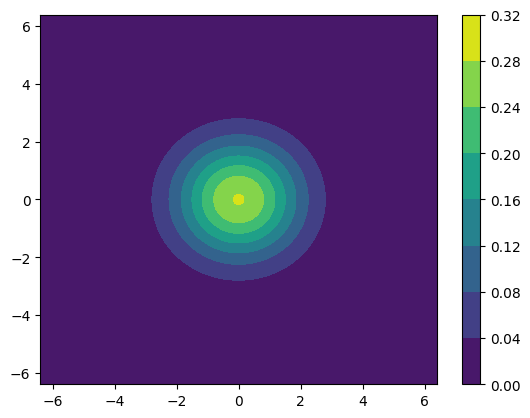

In [16]:
nv = 2048
vmax = 6.4
dv = 2*vmax/nv

v = np.linspace(-vmax+dv/2., vmax-dv/2., nv)
plt.contourf(v, v, (get_analytical_2d(0.001, 1000, v)))
plt.colorbar()

In [17]:
linear_solve_x = vmap(partial(lx.linear_solve, solver=lx.Tridiagonal()), in_axes=(None, 1))
linear_solve_y = vmap(partial(lx.linear_solve, solver=lx.Tridiagonal()), in_axes=(None, 0))

@jit
def solve_diff_2d(dt, finp, diff_coeff):
    coeff = -0.5*dt * diff_coeff / dv**2.
    diag = 1-jnp.concatenate([jnp.ones([1]), 2*jnp.ones_like(v[1:-1]), jnp.ones([1])])*coeff
    lower_diag = np.ones_like(v[1:])*coeff
    upper_diag = np.ones_like(v[1:])*coeff
    operator = lx.TridiagonalLinearOperator(diag, lower_diag, upper_diag)
    
    interm = finp + coeff*jnp.gradient(jnp.gradient(finp, axis=1), axis=1)
    interm = linear_solve_x(operator, interm).value
    interm = interm + coeff*jnp.gradient(jnp.gradient(interm, axis=0), axis=0)
    
    out = linear_solve_y(operator, interm).value
    
    return out

class VectorField(eqx.Module):
    """
    This function returns the function that defines $d_state / dt$

    All the pushers are chosen and initialized here and a single time-step is defined here.

    We use the time-integrators provided by diffrax, and therefore, only need $d_state / dt$ here

    :param cfg:
    :return:
    """
    v: jnp.ndarray
    dt: float
    kappa: float
    
    def __init__(self, v: jnp.ndarray, dt: float, kappa: float):
        super().__init__()
        self.v = v
        self.dt = dt
        self.kappa = kappa

    def __call__(self, t: float, y: jnp.ndarray, args):
        return solve_diff_2d(self.dt, y, self.kappa)

In [31]:
tmax = 1800
dt = 0.1
kappa = 0.001
t0 = 1000
nt = int((tmax-t0)/dt + 1)
val0 = get_analytical_2d(kappa, t0, v)

In [19]:
_t0_ = time()
val = np.copy(val0)
for i in tqdm(range(nt), total=nt):
    val = solve_diff_2d(dt, val, kappa)
print(f"{round(time() - _t0_, 3)} s")

100%|██████████| 100/100 [00:40<00:00,  2.49it/s]

40.129 s


In [32]:
_t0_ = time()
result = diffrax.diffeqsolve(terms=diffrax.ODETerm(VectorField(v, dt, kappa)), solver=Stepper(), max_steps=int(1e9), t0=t0, t1=tmax, dt0=dt, y0=jnp.array(val0), saveat=diffrax.SaveAt(ts=np.linspace(t0, tmax, 101)))
print(f"{round(time() - _t0_, 3)} s")

KeyboardInterrupt: 

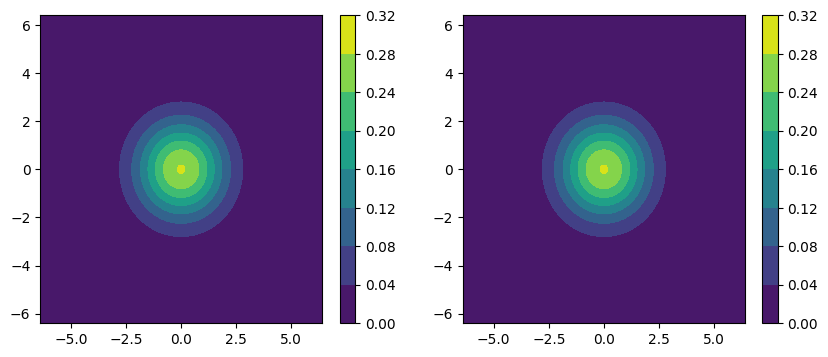

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

cb = ax[0].contourf(v, v, val0)
plt.colorbar(cb)

cb = ax[1].contourf(v, v, val)
plt.colorbar(cb)

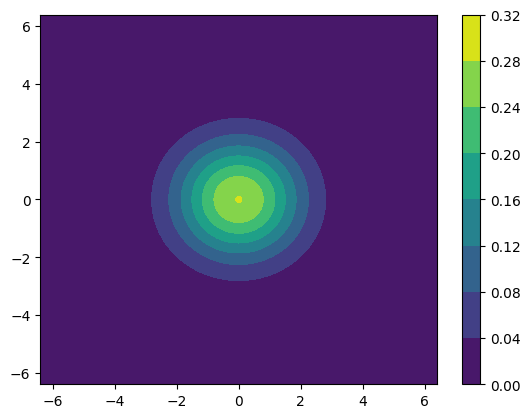

In [7]:
plt.contourf(v, v, (get_analytical_2d(0.001, t_start+nt*dt, v)))
plt.colorbar()

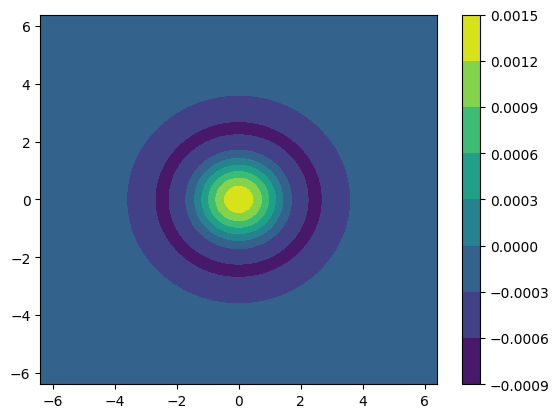

In [8]:
error = val - get_analytical_2d(0.001, t_start+nt*dt, v)
plt.contourf(v, v, error)
plt.colorbar()

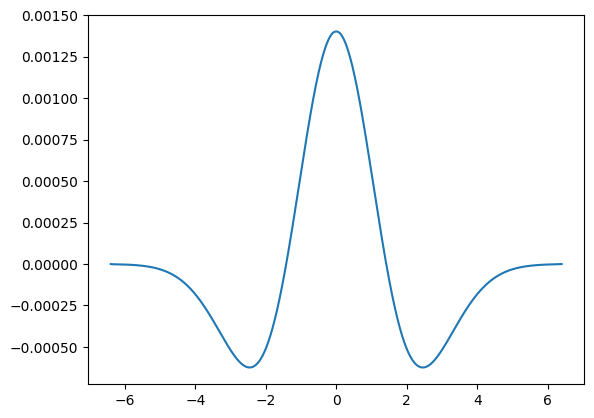

In [9]:
plt.plot(v, error[1024])

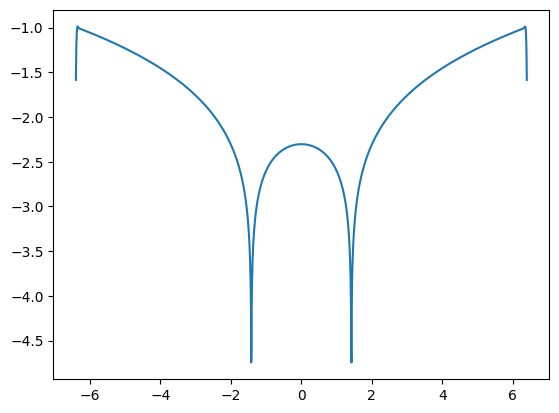

In [10]:
plt.plot(v, np.log10(np.abs(error[1024]/val[1024])))